<a href="https://colab.research.google.com/github/andreac941/ComputerVision-Eq3/blob/main/6_3_Modelado_Temas_LSI_LDA_semana6y7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**6.3 Actividad en Equipos - Semana 6 y 7. Modelado de Temas: LSI/LDA**

Equipo 20:
* Andrea Carolina Treviño Garza A01034993

En la actividad de esta semana trabajarás en equipos en el tema de modelado de temas (topic modeling).

In [41]:
#Líbrerías requeridas para la actividad:
import pandas as pd  
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import ast
import re

from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [42]:
!pip install gensim --upgrade --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:
[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]
* Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [43]:
with open('noticiasTopicModeling.txt', 'r') as fp:
  data = fp.read()
  details = ast.literal_eval(data)

list_texto = []
for x in details:
  list_texto.append(x["texto"])

df =pd.DataFrame(list_texto, columns=['noticia'])
print('Total de registros de noticias', df.shape)

Total de registros de noticias (5658, 1)


2. Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens que describan mejor la distribución de cada tema.

In [44]:
#Se guardan las Stopwords en español de archivo de texto:
with open('spanish.txt', 'r', encoding= 'utf8') as fp1:
  stopwords = fp1.readlines()
fp1.close()

my_stopwords = []
for p in stopwords:
  my_stopwords.append(re.sub(r'\n','',p))
print("Total de stopwords en español:",len(my_stopwords))
my_stopwords[0:5]

Total de stopwords en español: 608


['a', 'actualmente', 'adelante', 'además', 'afirmó']

In [45]:
#Se define función para proceso de limpieza y tokenización:
def clean_tok(doc):
  tokens = []
  global t1
  t1 = re.findall(r"[A-Za-záéíóúüñÁÉÍÓÚÜÑ]{3,}",doc)
  for i in t1:
    i = i.lower()
    if i not in my_stopwords:     
      tokens.append(i.lower())
  return tokens

In [46]:
#Se aplica función de limpieza y tokenización:
I = df.noticia
cleantok = [clean_tok(i) for i in I]

In [6]:
for x in cleantok[0:5]:
  print(x)

['españa', 'dejado', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'república', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'católica', 'papel', 'ley', 'creencias', 'pueblo', 'migración', 'integración', 'europea', 'programa', 'vox', 'europa', 'españa', 'domingo', 'noviembre', 'dejado', 'excepción', 'europa', 'potencia', 'extrema', 'derecha', 'parlamento', 'metáfora', 'precisamente', 'excepcional', 'dictadura', 'mediados', 'setenta', 'dictador', 'mausoleo', 'años', 'muerto', 'existía', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascistas', 'españa', 'pasó', 'portugal', 'italia', 'alemania', 'derrotó', 'fascismo', 'franquismo', 'murió', 'cama', 'harakiri', 'cortes', 'franquistas', 'ruptura', 'régimen', 'reforma', 'nació', 'país', 'país', 'mutó', 'ley', 'ley', 'aun', 'españa', 'parecía', 'vacunada', 'años', 'franquismo', 'bastantes', 'llegado', 'irrupción', 'posfranquismo', 'actores', 'fundamentales', 'gobiernos', 'autonómic

In [7]:
#Se define función para proceso de stemming:
sss = SnowballStemmer("spanish")

def clean_doc(doc):
  tokens = []
  for d in doc:
    tokens.append(sss.stem(d))
  return tokens

In [30]:
!pip install spacy_spanish_lemmatizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for spacy_spanish_lemmatizer: filename=spacy_spanish_lemmatizer-0.7-py3-none-any.whl size=10412 sha256=490e8ba04e336baa1b2bf4a931965374016b7fb2a58dceb6de0b6918a58800b0
  Stored in directory: /root/.cache/pip/wheels/f1/0f/46/69379c9b1be81b024ef47b671d16d13ffa81c0d9f06cb47b59
Successfully built spacy_spanish_lemmatizer


In [31]:
!python -m spacy download es_core_news_md

2023-06-04 01:46:38.283698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 01:46:40.006208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [38]:
!python -m spacy_spanish_lemmatizer download wiki

2023-06-04 02:04:44.693424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Decompressing dump file: /usr/local/lib/python3.10/dist-packages/spacy_spanish_lemmatizer/tmp/eswiktionary-latest-pages-articles.xml.bz2
Parsing downloaded file...
Generating lemmatization...
Exporting lemmatizer files...
Cleaning temporary files...


In [47]:
# INTENTO LEMATIZACIÓN ESPAÑOL:
import spacy
import spacy_spanish_lemmatizer
from spacy.lang.es.examples import sentences 
nlp = spacy.load("es_core_news_md") #es_core_news_sm
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

def clean_doc1(doc1):
  tokens = []
  nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
  tmp1 = ' '.join(doc1)
  for n in nlp(tmp1):
    tokens.append(n.lemma_)
  return tokens

In [48]:
clean1 = [clean_doc1(r) for r in cleantok]
clean1[0]

['españa',
 'dejado',
 'católico',
 'decir',
 'manuel',
 'azaña',
 'comienzo',
 'república',
 'congreso',
 'diputados',
 'aprobar',
 'ley',
 'laicistas',
 'metáfora',
 'católico',
 'papel',
 'ley',
 'creencias',
 'pueblo',
 'migración',
 'integración',
 'europeo',
 'programa',
 'vox',
 'europa',
 'españa',
 'domingo',
 'noviembre',
 'dejar',
 'excepción',
 'europa',
 'potencia',
 'extrema',
 'derecho',
 'parlamento',
 'metáfora',
 'precisamente',
 'excepcional',
 'dictadura',
 'mediados',
 'setenta',
 'dictador',
 'mausoleo',
 'año',
 'muerto',
 'existir',
 'cosa',
 'portugal',
 'grecia',
 'italia',
 'alemania',
 'países',
 'dictaduras',
 'fascista',
 'españa',
 'pasar',
 'portugal',
 'italia',
 'alemania',
 'derrotar',
 'fascismo',
 'franquismo',
 'morir',
 'cama',
 'harakiri',
 'corte',
 'franquista',
 'ruptura',
 'régimen',
 'reforma',
 'nacer',
 'país',
 'país',
 'mutar',
 'ley',
 'ley',
 'aun',
 'españa',
 'parecer',
 'vacunado',
 'año',
 'franquismo',
 'bastante',
 'llegado',
 'i

In [ ]:
#Original:
nlp = spacy.load("es")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

for token in nlp(
    """Con estos fines, la Dirección de Gestión y Control Financiero monitorea
       la posición de capital del Banco y utiliza los mecanismos para hacer un
       eficiente manejo del capital."""
):
    print(token.text, token.lemma_)

In [ ]:
# INTENTO LEMATIZACIÓN ESPAÑOL 2:


In [ ]:
clean = [clean_doc(r) for r in cleantok]
clean[0:5]

[['españ',
  'dej',
  'catol',
  'dec',
  'manuel',
  'azañ',
  'comienz',
  'republ',
  'congres',
  'diput',
  'aprob',
  'ley',
  'laicist',
  'metafor',
  'catol',
  'papel',
  'ley',
  'creenci',
  'puebl',
  'migracion',
  'integr',
  'europe',
  'program',
  'vox',
  'europ',
  'españ',
  'doming',
  'noviembr',
  'dej',
  'excepcion',
  'europ',
  'potenci',
  'extrem',
  'derech',
  'parlament',
  'metafor',
  'precis',
  'excepcional',
  'dictadur',
  'medi',
  'setent',
  'dictador',
  'mausole',
  'años',
  'muert',
  'exist',
  'cos',
  'portugal',
  'greci',
  'itali',
  'alemani',
  'pais',
  'dictadur',
  'fascist',
  'españ',
  'pas',
  'portugal',
  'itali',
  'alemani',
  'derrot',
  'fascism',
  'franquism',
  'mur',
  'cam',
  'harakiri',
  'cort',
  'franquist',
  'ruptur',
  'regim',
  'reform',
  'nac',
  'pais',
  'pais',
  'mut',
  'ley',
  'ley',
  'aun',
  'españ',
  'parec',
  'vacun',
  'años',
  'franquism',
  'bastant',
  'lleg',
  'irrupcion',
  'posfra

3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

In [ ]:
#Porque es un modelo No supervisado, no tenemos datos etiquetados, con los que podamos sobre entrenar el modelo 

##**Parte 1: Indexación semántica latente (LSI):**

4. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

In [49]:
ddf = []
for c in clean1:
  tmp = ' '.join(c)
  ddf.append(tmp)
ddf

ddf[0]

'españa dejado católico decir manuel azaña comienzo república congreso diputados aprobar ley laicistas metáfora católico papel ley creencias pueblo migración integración europeo programa vox europa españa domingo noviembre dejar excepción europa potencia extrema derecho parlamento metáfora precisamente excepcional dictadura mediados setenta dictador mausoleo año muerto existir cosa portugal grecia italia alemania países dictaduras fascista españa pasar portugal italia alemania derrotar fascismo franquismo morir cama harakiri corte franquista ruptura régimen reforma nacer país país mutar ley ley aun españa parecer vacunado año franquismo bastante llegado irrupción posfranquismo actor fundamental gobierno autonómico local ciudadano españa dejar excepción alianza popular manuel fraga beber franquismo sociológico fuerza blas piñar búnker franquista franquismo sociológico mantener tiempo vox escisión españa reinstauración democrático existido fuerza extrema derecho voto escaños fenómeno pas

In [50]:
tfidf = TfidfVectorizer(max_df=2, min_df=1)

tfidf_sparse = tfidf.fit_transform(ddf)

In [51]:
tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out()) 

print(tfidf_dense.iloc[0:5,80:90])

   abdikadir  abdkarim  abducir  abdulrahman  abdulá  abdurraqib  abea  abeba  \
0        0.0       0.0      0.0          0.0     0.0         0.0   0.0    0.0   
1        0.0       0.0      0.0          0.0     0.0         0.0   0.0    0.0   
2        0.0       0.0      0.0          0.0     0.0         0.0   0.0    0.0   
3        0.0       0.0      0.0          0.0     0.0         0.0   0.0    0.0   
4        0.0       0.0      0.0          0.0     0.0         0.0   0.0    0.0   

   abedrapo  abedzadeh  
0       0.0        0.0  
1       0.0        0.0  
2       0.0        0.0  
3       0.0        0.0  
4       0.0        0.0  


In [52]:
tfidf_dense.shape

(5658, 44140)

5. Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [53]:
r = 10
lsi_obj = TruncatedSVD(n_components = r, 
                       n_iter=100,  
                       random_state=42)

tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse)
Sigma = lsi_obj.singular_values_
V_T = lsi_obj.components_.T     

In [54]:
sigmas = lsi_obj.singular_values_

sigmas

array([1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356])

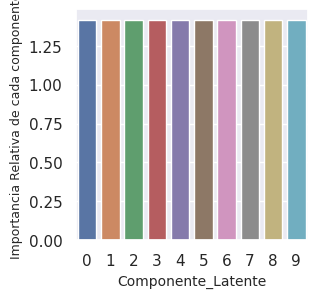

In [55]:
sns.set(rc={'figure.figsize':(3,3)}) 
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉􀯍 de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [56]:
lsi_term_topic = V_T 

print(lsi_term_topic.shape)

(44140, 10)


In [57]:
term_names = list(tfidf.get_feature_names_out())

term_topic_matrix = pd.DataFrame(data=lsi_term_topic, 
                                 index = term_names,   
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics

(44140, 10)


In [58]:
term_topic_matrix.head()

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
aaas,1.424755e-12,5.808071e-12,-8.636989e-12,-1.039233e-11,-9.816664e-12,-1.795191e-12,-3.740662e-12,4.457888e-12,-3.340221e-12,-4.352597e-12
aac,1.471745e-16,3.484967e-16,1.047897e-16,-1.587946e-16,7.694228e-16,9.944315e-17,-1.726789e-16,-4.335490e-16,2.363425e-16,8.342789e-16
aahjko,-8.897317e-14,-1.222633e-13,-3.646194e-14,-2.238659e-15,-5.602739e-14,-1.402252e-13,6.755523e-14,1.375580e-12,1.886082e-12,1.497398e-12
aai,-3.962811e-13,-1.649953e-12,-7.359474e-13,6.168610e-13,-3.883413e-12,-1.627422e-12,2.034164e-12,-3.910251e-13,5.295598e-12,8.017196e-12
aaim,-4.695466e-12,-2.477449e-12,-9.979799e-13,-4.718187e-13,2.974323e-12,7.985503e-13,7.342485e-14,-2.166935e-12,3.373874e-12,1.505468e-12


7. Con base a la cantidad de conceptos latentes que determinaste en el ejercicio 6 anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes?

In [ ]:
#NOTA: profesor mandó correo indicando que preguntas 7 y 8 se consideran como una misma pregunta.

8. Para cada uno de los 10 conceptos latentes obtenidos con la descomposición SVD del ejercicio 5, obtener el gráfico de barras que muestre los 10 términos/tokens más importantes de cada uno de ellos.

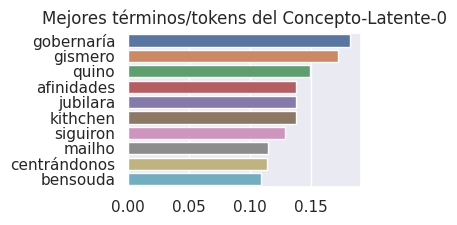

In [59]:
# Seleccionemos por ejemplo una de las columnas/tópico "Concepto_Latente":

data = term_topic_matrix[f'Concepto_Latente_0']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-0')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

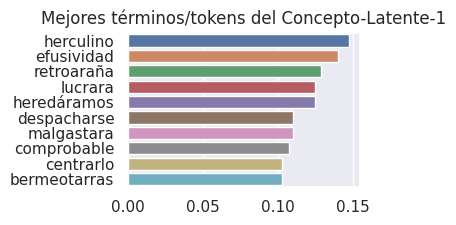

In [60]:
data = term_topic_matrix[f'Concepto_Latente_1']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-1')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

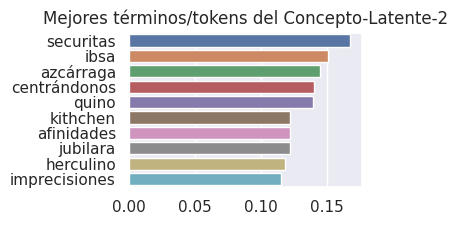

In [61]:
data = term_topic_matrix[f'Concepto_Latente_2']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-2')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

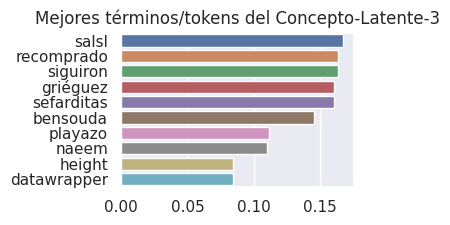

In [62]:
data = term_topic_matrix[f'Concepto_Latente_3']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-3')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

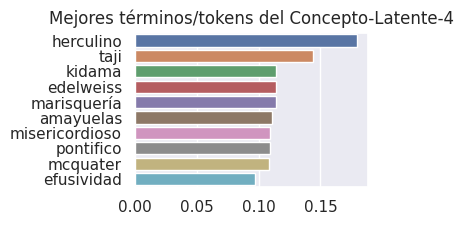

In [63]:
data = term_topic_matrix[f'Concepto_Latente_4']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-4')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

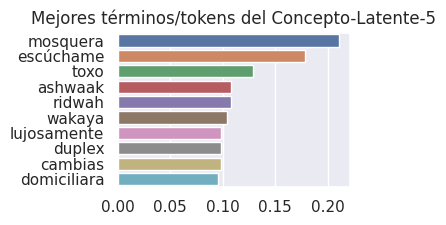

In [64]:
data = term_topic_matrix[f'Concepto_Latente_5']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-5')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

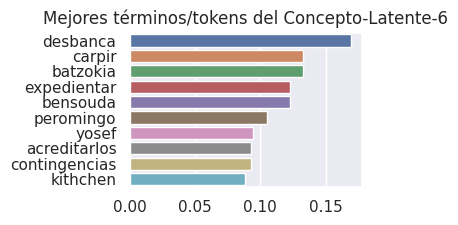

In [65]:
data = term_topic_matrix[f'Concepto_Latente_6']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-6')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

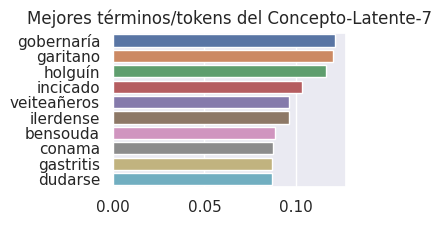

In [66]:
data = term_topic_matrix[f'Concepto_Latente_7']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-7')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

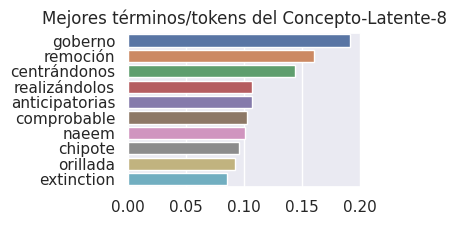

In [67]:
data = term_topic_matrix[f'Concepto_Latente_8']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-8')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

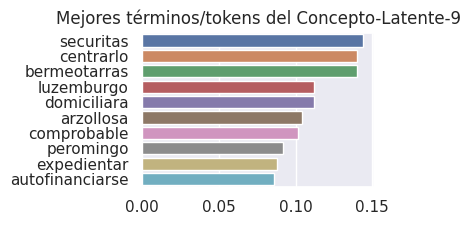

In [68]:
data = term_topic_matrix[f'Concepto_Latente_9']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-9')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

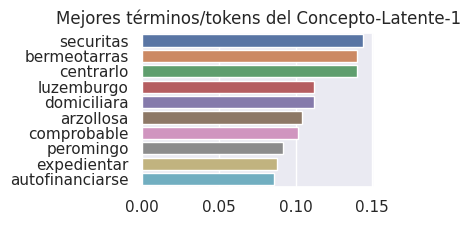

In [69]:
#TEST DESPLEGAR EN SUBPLOTs:
data0 = term_topic_matrix[f'Concepto_Latente_0']
data1 = term_topic_matrix[f'Concepto_Latente_1']
data2 = term_topic_matrix[f'Concepto_Latente_2']
data3 = term_topic_matrix[f'Concepto_Latente_3']
data4 = term_topic_matrix[f'Concepto_Latente_4']
data5 = term_topic_matrix[f'Concepto_Latente_5']
data6 = term_topic_matrix[f'Concepto_Latente_6']
data7 = term_topic_matrix[f'Concepto_Latente_7']
data8 = term_topic_matrix[f'Concepto_Latente_8']
data9 = term_topic_matrix[f'Concepto_Latente_9']

top_w = 10 
dataN = ["data"+str(i) for i in range(0,10)]
Con_Lat = ["Concepto_Latente_"+str(i) for i in range(0,10)]
top_w_matrixN = ["top_w_matrix"+str(i) for i in range(0,10)]
new_top = []
#for i,j,k in dataN, Con_Lat, top_w_matrixN:
#  i = term_topic_matrix[f'{j}']
#  i = i.sort_values(ascending=False)
#  k = i[:top_w] 
#  new_top.append(k)

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.    

#top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a 
                               # los top_w terms (words).

#dataN = [" "]
titles = ['Mejores términos/tokens del Concepto-Latente-0', 'Mejores términos/tokens del Concepto-Latente-1', 'Mejores términos/tokens del Concepto-Latente-2', 'Mejores términos/tokens del Concepto-Latente-3', 'Mejores términos/tokens del Concepto-Latente-4', 'Mejores términos/tokens del Concepto-Latente-5', 'Mejores términos/tokens del Concepto-Latente-6', 'Mejores términos/tokens del Concepto-Latente-7', 'Mejores términos/tokens del Concepto-Latente-8', 'Mejores términos/tokens del Concepto-Latente-9']
sns.set(rc={'figure.figsize':(3,2)}) 
plt.title('Mejores términos/tokens del Concepto-Latente-1')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

9. Con base a los resultados del ejercicio anterior, ¿cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?

10. La librería de código abierto Gensim, incluye la implementación de la técnica LSI. Ver
documentación: https://radimrehurek.com/gensim/models/lsimodel.html
* Investiga la documentación de este modelo LSI en Gensim y aplica dicha técnica a tu conjunto de
datos. En particular, obtener los modelos de 2 a 10 temas/tópicos y para cada uno de ellos obtener su valor (score) de coherencia. Con base a dichos valores, ¿qué cantidad de tópicos sería el adecuado? ¿Coincide con lo que obtuviste previamente, usando la técnica SVD de manera directa?

In [70]:
mi_dicc = corpora.Dictionary(clean1)     # generamos el diccionario

bow = [mi_dicc.doc2bow(doc) for doc in clean1]   # y luego la BOW

In [72]:
for i in range(2,15):
    
    lsi = LsiModel(bow, 
                   num_topics=i, 
                   id2word=mi_dicc,
                   chunksize=6,
                   random_seed=7
                  )     
    
    cm = CoherenceModel(model=lsi, 
                        texts=clean, 
                        dictionary=mi_dicc, 
                        window_size=3,
                        coherence='c_v',
                        topn = 3
                       )
    
    cs = cm.get_coherence()
    
    print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

KeyboardInterrupt: ignored

In [ ]:
best_Nclusters = 10

In [ ]:
# Seleccionas el mejor de los anteriores:

lsi = LsiModel(bow, 
               num_topics=5, 
               id2word=mi_dicc,
               chunksize=6,
               random_seed=7
               )

# Veamos la manera en que se distribuyen los términos en cada tópico generado:
for topic_num, words in lsi.print_topics(num_words=10):
    print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))

##**Parte 2: Asignación de Dirichlet Latente (LDA):**

11. Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable:
* https://radimrehurek.com/gensim/models/ldamodel.html
* https://radimrehurek.com/gensim/models/ldamulticore.html

In [ ]:
# generamos el diccionario:

id2word = corpora.Dictionary(clean)

for id in range(7):
    print(id2word[id])

In [ ]:
corpus = [id2word.doc2bow(doc) for doc in clean]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=3,      # total de tópicos que deseas buscar...
                    chunksize=5,    # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,        # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.2,        # alfa: similaridad document-topics
                    eta=0.2,         # beta: similaridad topic-words      
                    )

In [ ]:
lda_model.print_topics(num_topics= best_Nclusters, num_words=10)

12. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus
resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras
puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a
considerar?

13. La librería pyLDAvis nos ayuda a visualizar de manera interactiva los temas y tokens de los documentos analizados. Revisa la documentación y utilízala para visualizar tus mejor resultado.
* https://pypi.org/project/pyLDAvis/

14. Incluye tus conclusiones finales de la actividad.

###**Conclusiones:**

* Se con..

NOTA: Esta actividad está distribuida en 2 semanas. Aunque la primera parte de esta actividad se
considera para evaluar la primera semana y la segunda parte para la segunda semana, la entrega de toda la
actividad será hasta el final de la segunda semana en un solo documento. Al hacer la evaluación de la
actividad se distribuirán las calificaciones en cada semana.

In [ ]:
#código de: https://keepcoding.io/blog/que-es-la-lematizacion-en-python/  & https://github.com/michmech/lemmatization-lists/blob/master/lemmatization-es.txt
import os

#Lematización en Python
data_path = ' ./data'
lemmas_dict_file = 'lemmatization-es.txt'
path = '/content/lemmatization-es.txt'

#Lematización en Python
def get_lemmas_dict ():
       lemmas_dict = {}
       with open (path, 'r') as f: #/content/lemmatization-es.txt
               for line in f:
                     (key, val) = line.split ()
                     lemmas_dict [str (val)] = key
       return lemmas_dict

#Lematización en Python
lemmas_dict = get_lemmas_dict ()

#for f in range(5):
#  print(lemmas_dict.items(f))


#Bibliografía:
#https://snyk.io/advisor/python/spacy-spanish-lemmatizer